In [2]:
from lasagne.generative.autoencoder import Autoencoder, greedy_learn_with_validation
from lasagne.easy import BatchOptimizer, LightweightModel
from lasagne.datasets.mnist import MNIST
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne import layers, updates, init, nonlinearities
import theano.tensor as T
from theano.sandbox import rng_mrg
import theano
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using gpu device 0: Tesla K20m


# Load & pre-process data

In [3]:
data = MNIST()
data.load()
X = data.X

In [4]:
w, h = 28, 28

In [5]:
from skimage.filter import threshold_otsu
from skimage.transform import resize
X_b = np.zeros((X.shape[0], w, h))
for i in range(X_b.shape[0]):
    X_b[i] = resize(X[i].reshape((28, 28)), (w, h))
X = X_b
X = X <= threshold_otsu(X)
X = X.astype(np.float32)
X = 1 - X
X = X.reshape((X.shape[0], w*h))

In [6]:
X = shuffle(X)
train, test = train_test_split(range(X.shape[0]), test_size=0.25)

In [7]:
class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        code, = self.model.encode(X[0:100])
        status["act_mean"] = code.mean()
        status["act_std"] = code.std()
        return status

## Model definition

In [8]:
def cross_entropy(truth, pred):
    return -(truth * T.log(pred) + (1 - truth) * T.log(1 - pred)).sum(axis=1).mean()

def build_batch_optimizer():
    batch_optimizer = MyBatchOptimizer(
        verbose=1,
        max_nb_epochs=100,
        batch_size=100,
        optimization_procedure=(updates.momentum, {"learning_rate": 0.01, "momentum": 0.8}),
        
    )
    return batch_optimizer


def corrupted_masking_noise(rng, x, corruption_level):
    return rng.binomial(size=x.shape, n=1, p=1 - corruption_level) * x

def corrupted_salt_and_pepper(rng, x, corruption_level):
    selected = rng.binomial(size=x.shape, n=1, p=corruption_level, dtype=theano.config.floatX)
    return x * (1 - selected) + selected * rng.binomial(size=x.shape, n=1, p=0.5, dtype=theano.config.floatX)

rng = rng_mrg.MRG_RandomStreams()
 
def corruption_function(X):
    return corrupted_salt_and_pepper(rng, X, 0.3)
    
def build_model(i, o, corruption=False, batch_optimizer=None):
    if batch_optimizer is None:
        bo = build_batch_optimizer()
    else:
        bo = batch_optimizer
    x_in = layers.InputLayer((None, i))
    z_out = layers.DenseLayer(x_in, num_units=o,
                              nonlinearity=nonlinearities.sigmoid)
    x_to_z = LightweightModel([x_in], [z_out])

    z_in = layers.InputLayer((None, o))
    x_out = layers.DenseLayer(z_in, num_units=i,
                              nonlinearity=nonlinearities.sigmoid)
    z_to_x = LightweightModel([z_in], [x_out])
    noise_function = corruption_function if corruption is True else None
    aa = Autoencoder(x_to_z,
                     z_to_x,
                     batch_optimizer=bo,
                     noise_function=noise_function,
                     loss_function=cross_entropy)
    aa.W = z_out.W
    aa.W_inv = x_out.W
    aa.batch_optimizer.layers = [z_out]
    return aa

def build_models(input_size):
    models = [
        build_model(input_size, 500, corruption=True),
        build_model(500, 250),
        build_model(250, 128),
    ]
    return models

In [9]:
models = build_models(X.shape[1])

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/init.py:91: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


In [10]:
greedy_learn_with_validation(models, (train, test), X)

  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      0     40.1273       134.696       99.1051            98.9301            99.0884    0.466739    0.31858
  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      1     5.51719       89.0817       82.2094            81.8082            82.1597    0.471368   0.335596
  epoch    loss_std    loss_train    loss_valid    rec_error_train    rec_error_valid    act_mean    act_std
-------  ----------  ------------  ------------  -----------------  -----------------  ----------  ---------
      2     3.24573       77.8359       74.7455            74.3377            74.7751    0.476441    0.34146
  epoch    loss_std

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/easy.py:845: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
  for output_layer in self.output_layers]
/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


ValueError: dimension mismatch in args to gemm (100,784)x(500,250)->(100,250)
Apply node that caused the error: GpuDot22(GpuFromHost.0, W)
Inputs types: [CudaNdarrayType(float32, matrix), CudaNdarrayType(float32, matrix)]
Inputs shapes: [(100, 784), (500, 250)]
Inputs strides: [(784, 1), (250, 1)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

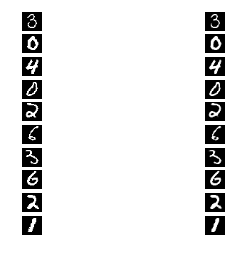

In [11]:

r = np.arange(X.shape[0])
np.random.shuffle(r)
r = r[0:10]

X_hat = models[0].recover_function(X)
imshape = ((X.shape[0], w, h))

X_hat = X_hat.reshape(imshape)
X_ = X.reshape(imshape)
k = 0
for i in r:
    plt.subplot(len(r), 2, k + 1)
    plt.axis('off')
    plt.imshow(X_[i], cmap='gray')
    plt.subplot(len(r), 2, k + 2)
    plt.imshow(X_hat[i], cmap='gray')
    plt.axis('off')
    k += 2

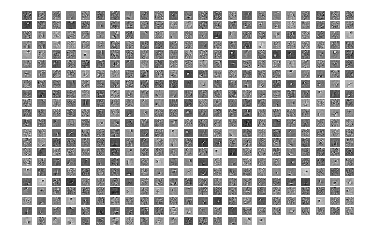

In [21]:
from lasagne.misc.plot_weights import grid_plot
W = models[0].W.get_value().T
W = W.reshape((W.shape[0], w, h))
W = W[0:500]
grid_plot(W, imshow_options={"cmap": "gray"})
plt.show()

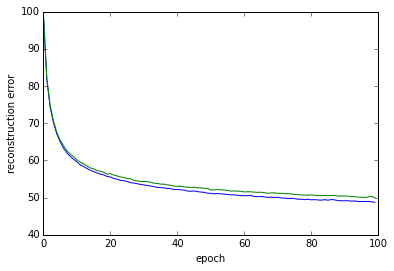

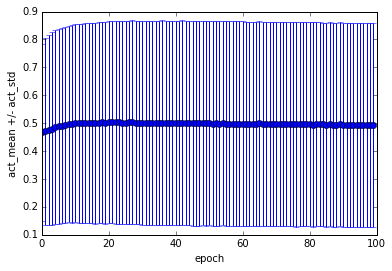

In [20]:
from lasagne.easy import get_stat

layer = 0
train = get_stat("rec_error_train", models[layer].batch_optimizer.stats)
test = get_stat("rec_error_valid", models[layer].batch_optimizer.stats)

plt.plot(train)
plt.plot(test)
plt.xlabel("epoch")
plt.ylabel("reconstruction error")
plt.show()

epoch = get_stat("epoch", models[layer].batch_optimizer.stats)
act_mean = get_stat("act_mean", models[layer].batch_optimizer.stats)
act_std = get_stat("act_std", models[layer].batch_optimizer.stats)

plt.errorbar(epoch, act_mean, yerr=act_std, fmt='-o')
plt.xlabel("epoch")
plt.ylabel("act_mean +/- act_std")